# Housing Agent Model based on Geographic distances

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
import pandas as pd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
%matplotlib inline

## Define City and District data (This segment of the code is the only thing that changes when you change cities)

In [3]:
# Define the city you want to analyze
place_name = "Barcelona, Spain"

# Download district borders. Here make sure admin level matches district level by observing borders df
borders = ox.features_from_place(place_name, tags={"boundary": "administrative", "admin_level": "2"})

# Probably there will be repeated districts in the df so just select the desired ones with a similar method as below. Perhaps changing 'ref' column name and the end of range to num of districts + 1.
districts_within_city = borders[borders['ref'].isin([str(i) for i in range(1, 11)])]

# Gets city boundary
city_boundary = ox.geocode_to_gdf(place_name, which_result = 1) 

# Gets districts within city obundary
districts_within_city = gpd.sjoin(districts_within_city, city_boundary, how = "inner", predicate = 'within')[: 10]

# Add district names and mean rent values. The names have to be exact matches to the districts_within_city df names.
district_prices = {
    'Ciutat Vella': 784,
    'Eixample': 676,
    'Sants-Montjuïc': 572,
    'les Corts': 600,
    'Sarrià - Sant Gervasi': 688,
    'Gràcia': 628,
    'Horta-Guinardó': 496,
    'Nou Barris': 516,
    'Sant Andreu': 500,
    'Sant Martí': 640}


# Download the road network data
road_graph = ox.graph_from_place(place_name, network_type = "drive")

# Convert to GeoDataFrame for easier manipulation
road_df = ox.graph_to_gdfs(road_graph, nodes = False)

# Download parks
parks = ox.features_from_place(place_name, tags = {"leisure" : "park"})

# Download schools
schools = ox.features_from_place(place_name, tags = {'amenity' : 'school'})

# Download health centers
hospitals = ox.features_from_place(place_name, tags = {'amenity' : 'hospital'}) # Does not include clinics 

# Download supermarkets
supermarkets = ox.features_from_place(place_name, tags = {'shop' : 'supermarket'})
supermarkets = supermarkets.dropna(subset = ['brand']) # Ensures only branded supermarkets are included
supermarkets = supermarkets.dropna(subset = ['addr:postcode']) # Ensures only main supermarkets are included

# Download landmarks
landmarks = ox.features_from_place(place_name, tags = {'tourism' : 'attraction'})

# Download Beach (natural : beach) or Coastline (natural : coastline). For Cities With rivers might be worth downloading rivers too?
coastline = ox.features_from_place(place_name, tags = {'natural' : 'beach'})

# Download residential areas
residential_areas = ox.features_from_place(
    place_name, tags = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'annexe', 'farm', 'house', 'houseboat', 'residential', 'semidetached_house', 'terrace']})

## Plotting a detailed view of the city

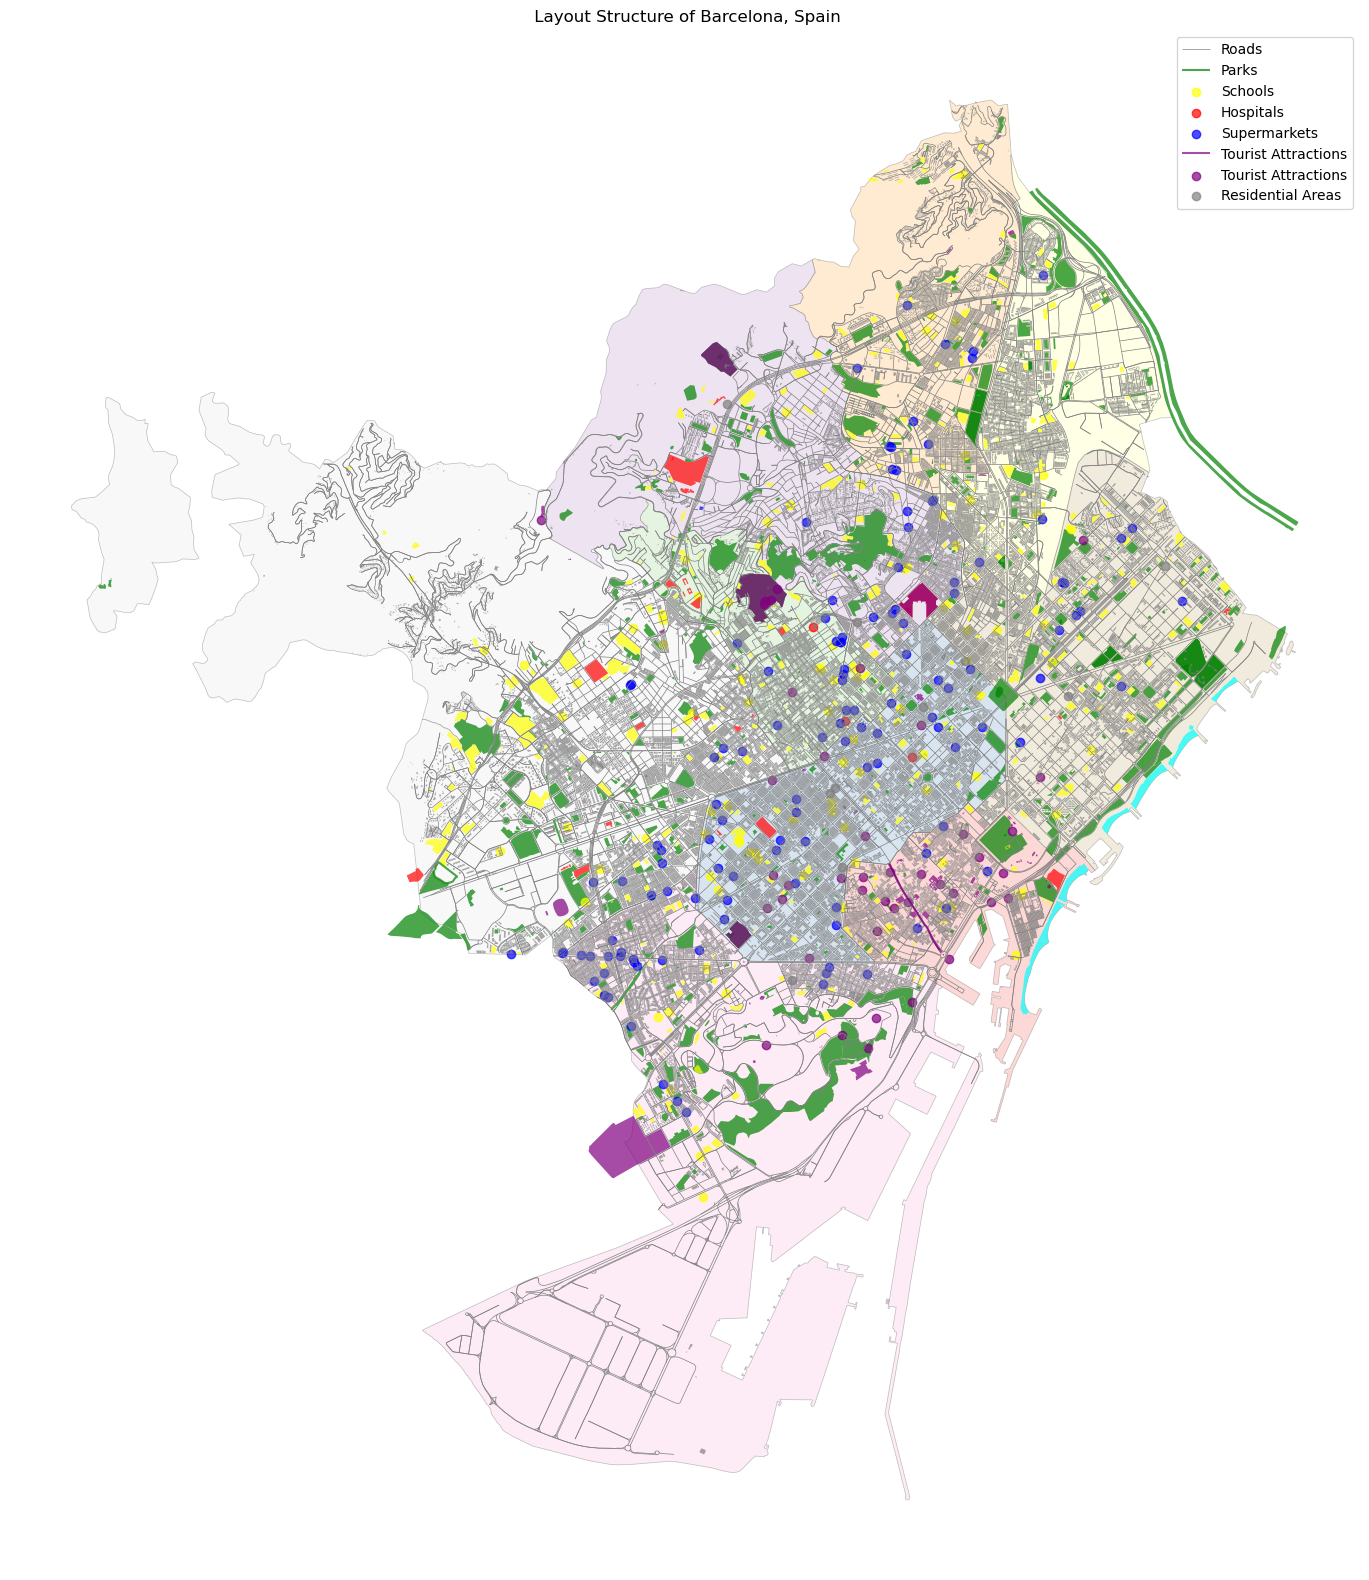

In [5]:
# Initialize Plot
fig, ax = plt.subplots(figsize = (20, 20))

# Plot each district with a unique color using a colormap
districts_within_city.plot(ax=ax, column = 'name_left', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, legend = True, alpha = 0.5)

# Plot roads
road_df.plot(ax = ax, color = 'gray', linewidth = 0.5, label = "Roads")

# Plot parks
parks.plot(ax = ax, color = 'green', alpha = 0.7, label = "Parks")

# Plot schools
schools.plot(ax = ax, color = 'yellow', alpha = 0.7, label = "Schools")

# Plot health centers
hospitals.plot(ax = ax, color = 'red',alpha = 0.7, label = "Hospitals")

# Plot supermarkets
supermarkets.plot(ax = ax, color = 'blue',alpha = 0.7, label = "Supermarkets")

# Plot landmarks
landmarks.plot(ax = ax, color='purple',alpha = 0.7, label = "Tourist Attractions")

# Plot beach
coastline.plot(ax = ax, color = 'cyan',alpha = 0.7, label = "Beach")

# Plot residential areas
residential_areas.plot(ax = ax, color = 'grey',alpha = 0.7, label = "Residential Areas")

# Label each district with its name : not in use rn
#for x, y, label in zip(districts_within_city.geometry.centroid.x, districts_within_city.geometry.centroid.y, districts_within_city["name_left"]):
    #ax.text(x, y, label, fontsize=10, ha='center', color='black')

# Customize and display Plot
ax.axis("off")
plt.legend()
plt.title(f" Layout Structure of {place_name}")
plt.show()

### Initialize Reduced map layouts. Includes agent and amenity placing.

**Note:** Agent placing is exact and matches desired amount. Amenity placing is slightly less than specified amount. Would be good to look at this again.

park will have 43 amenities
school will have 35 amenities
hospital will have 2 amenities
supermarket will have 9 amenities
landmark will have 8 amenities
beach will have 1 amenities


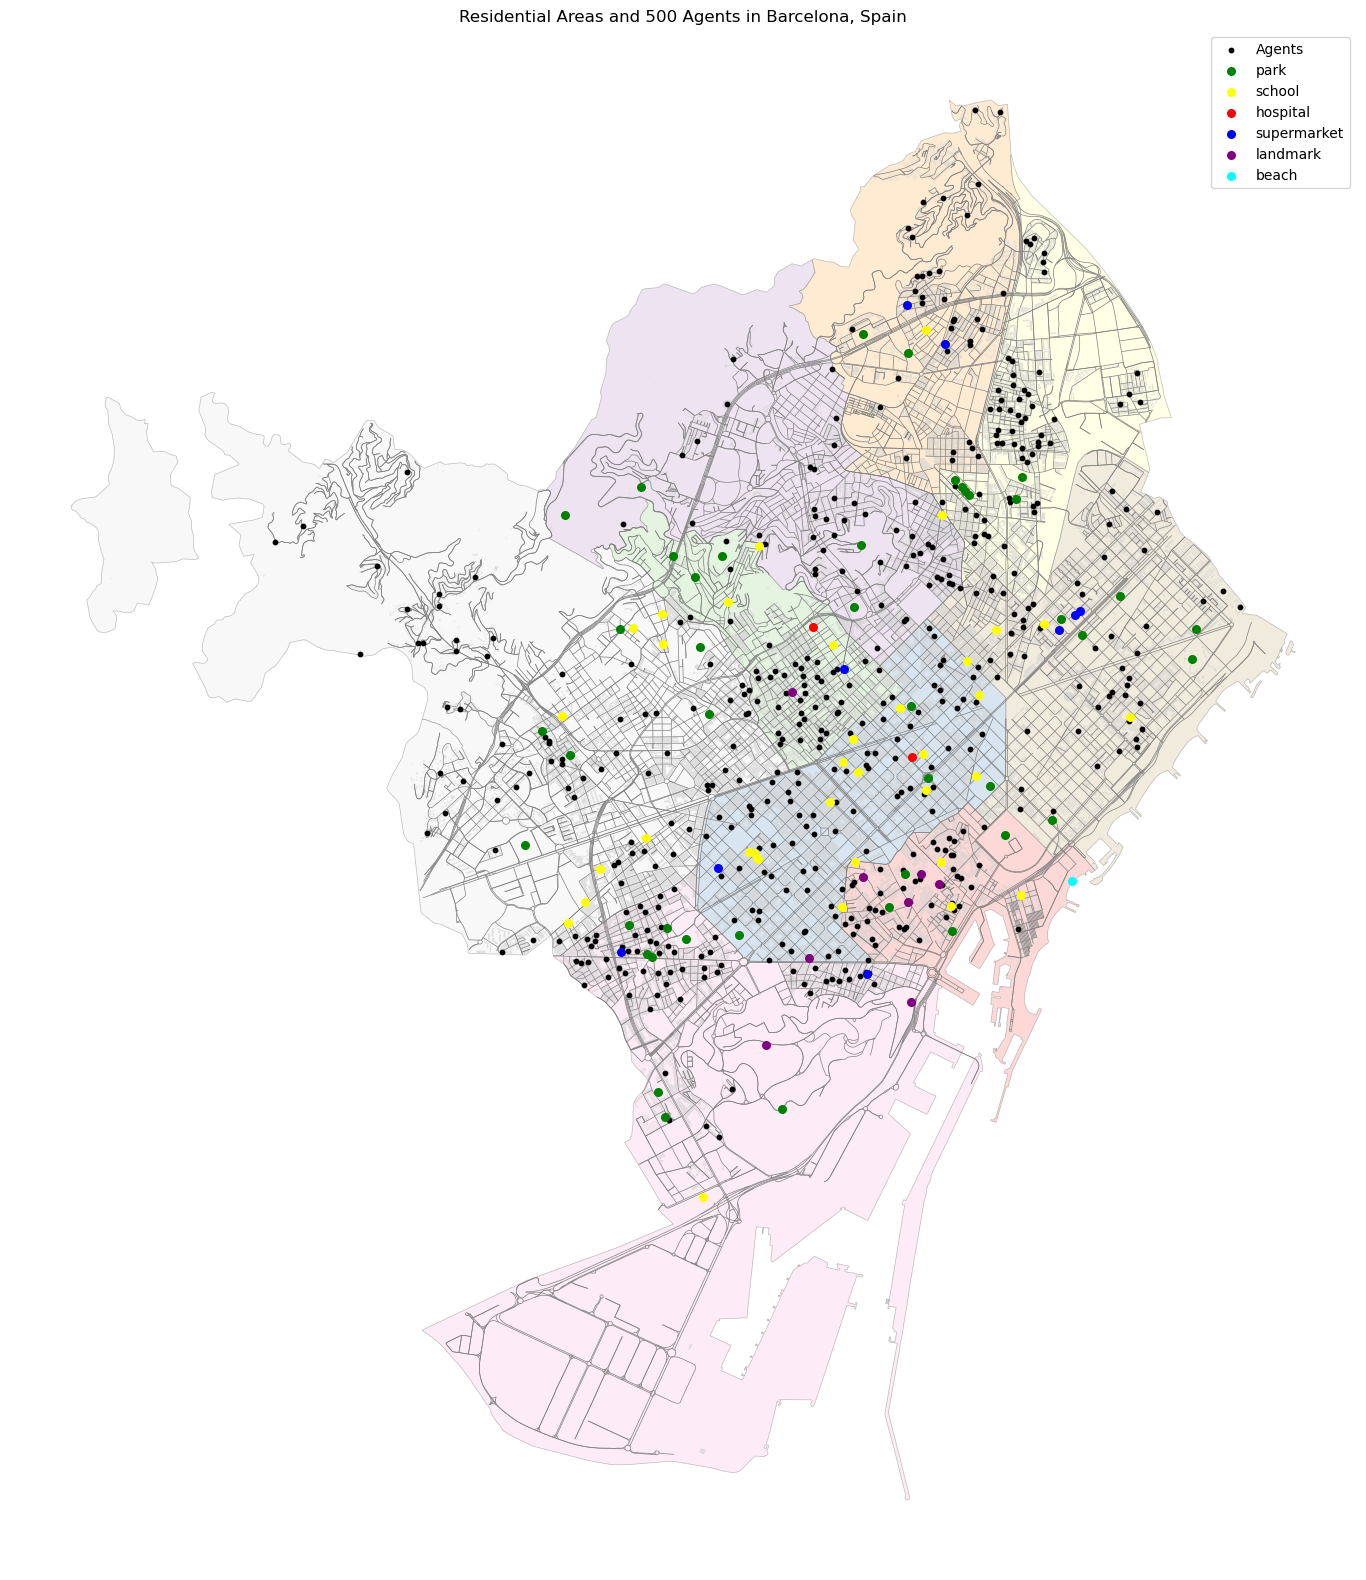

In [34]:
# Convert Residential from coordinate to metric system. Note: epsg defines the coordinate system we want to use.
residential_areas_conv = residential_areas.to_crs(epsg = 3857)

# Specify the number of agents to be placed
num_agents = 500 

# Specify the number of amenities to be placed
num_amenities = 100 

# Initialize agent and amenity lists
agents = []
amenities = []

# AGENT PLACING:

# Calculate total residential areas in map
total_areas = len(residential_areas)

# Calculate how many areas to skip between agent placements
skip_interval_agents = total_areas // num_agents

# Intialize allocated agent count
allocated_agents = 0

# Iterate over residential areas and place agents
for i, (_, row) in enumerate(residential_areas.iterrows()):
    
    # Only place agents at every skip_interval-th residential area and as long as number doesn't exceed our desired amount
    if i % skip_interval_agents == 0 and allocated_agents < num_agents:
        
        # Get the centroid coordinates of the residential area
        centroid = row['geometry'].centroid
        agents.append((centroid.x, centroid.y, 'agent'))
        allocated_agents += 1     

# AMENITY PLACING:

# Intialize allocated agamenity count
allocated_amenities = 0

# Define Desired amenity types and calculate total number of amenities in map

amenity_types = [parks, schools, hospitals, supermarkets, landmarks, coastline]
total_amenities = len(parks) + len(schools) + len(hospitals) + len(supermarkets) + len(landmarks) + len(coastline)

# Define desired amenity colors
amenity_colors = {
    'park': 'green',
    'school': 'yellow',
    'hospital': 'red',
    'supermarket': 'blue',
    'landmark': 'purple',
    'beach': 'cyan'}

# Iterate over amenities in map and place dot amenities
for geo, amenity_type in zip(amenity_types, 
                             ['park', 'school', 'hospital', 'supermarket', 'landmark', 'beach']):
    
    # Calculate the number of dot amenities for each type of amenity by their respective proportions in map
    amenities_for_geo = max(int((len(geo) / total_amenities) * (num_amenities) // 1), 1)
    
    # Add number to allocated amenities
    allocated_amenities += amenities_for_geo
    
    # If allocated amenities is in desired range aggregate amenities
    if allocated_amenities <= num_amenities:
        
        # Print how many amenities this amenity type is getting
        print(f"{amenity_type} will have {amenities_for_geo} amenities")
        
        
        for i, (_, row) in enumerate(geo.iterrows()):
            if i // amenities_for_geo == 0 : 
                
                 # Get and store the centroid coordinates and the feature type
                centroid = row['geometry'].centroid
                amenities.append((centroid.x, centroid.y, amenity_type)) 
                
# Plot the residential areas, roads, and districts

fig, ax = plt.subplots(figsize=(20, 20))

districts_within_city.plot(ax=ax, column = 'name_left', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)
road_df.plot(ax = ax, color = 'gray', linewidth = 0.5)
residential_areas.plot(ax=ax, color='lightgray', alpha=0.7)
# Unzip the agent and amenity positions
agents_x, agents_y, _ = zip(*agents)  
amenities_x, amenities_y, amenities_type = zip(*amenities)

# Plot the agents as red dots
ax.scatter(agents_x, agents_y, color='black', label="Agents", s=10, zorder=5)

 # Plot the points for each amenity type
for i in range(len(amenities)):
    amenity = amenities[i]
    if i == 0 or amenity[2] != amenities[i - 1][2]: 
        ax.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], label = amenity[2], s = 30, zorder = 5)
    else:
        ax.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], s = 30, zorder = 5)

# Customize plot and display it
ax.set_title(f"Residential Areas and {num_agents} Agents in {place_name}")
ax.legend()
ax.axis("off")
plt.show()

# Add District labels to agents according to position

# Convert agents and amenities from list of tuples to a DataFrame
amenities_df = pd.DataFrame(amenities, columns=["longitude", "latitude", "type"])
df = pd.DataFrame(agents, columns=["longitude", "latitude", "type"]).drop(columns=["type"])

# Create a geometry column from the latitude and longitude
df['geometry'] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis = 1)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry = "geometry", crs = 'EPSG:4326')

# Reduce districts DataFrame to only desired columns
districts_within_city = districts_within_city[['name_left', 'geometry']]

# Append respective district to agents
agents_with_districts = gpd.sjoin(gdf, districts_within_city, how = "left", predicate = 'within')
agents_with_districts = agents_with_districts[['latitude', 'longitude', 'name_left']]

## Custom functions based on previous grid-based model that now work using geographic locations and distances

### Functions Pre-Amenity modifications 

In [35]:
def initial_price_dist(agents_df, district_prices):
    '''
    Assign an initial house price based on the 'District' column in agents_df.
    Inputs:
    agents_df (DataFrame): DataFrame with columns 'x_coord', 'y_coord', 'District', and 'price'
    district_prices (dict): Dictionary mapping each district to an initial price
    '''
    # Assign house prices based on the district
    agents_df['price'] = agents_df['name_left'].map(district_prices)

    return agents_df

def initial_affluence_dist(n, a, p, agents_df):
    '''
    Assign random affluence to each agent based on provided affluence groups and proportions
    Inputs:
    n (int): number of agents
    a (array): affluence group parameters 
    p (array): proportions of affluence groups
    agents_df (DataFrame): DataFrame with columns 'x_coord', 'y_coord', and 'affluence'
    '''
    # Assign a random affluence to each agent
    affluence_list = np.random.choice(a, size=n, p=p)
    
    # Update the agents DataFrame with affluence values
    agents_df['affluence'] = affluence_list

    return agents_df


def update_house_prices(df, weight, radius):
    '''
    Update all house values in the DataFrame by calculating new values using householder affluence 
    and neighborhood average price within a specified radius based on geographic coordinates, 
    optimized with spatial indexing (cKDTree).

    Parameters:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'name_left', 'affluence', 'price'].
    weight (float): Weight for neighborhood average in calculating updated price.
    radius (float): Radius within which to calculate neighborhood average (in kilometers).

    Returns:
    df (DataFrame): DataFrame with updated house prices.
    '''
    
    # Create a copy of the DataFrame to avoid modifying the original
    updated_df = df.copy()

    # Extract coordinates into a numpy array for spatial indexing
    coords = df[['latitude', 'longitude']].values
    
    # Create a cKDTree for fast spatial queries
    tree = cKDTree(coords)

    # Iterate over each row in the DataFrame
    for index, row in updated_df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        affluence = row['affluence']
        
        # Query the kDTree to find neighbors within the given radius (in kilometers)
        neighbors_idx = tree.query_ball_point([lat, lon], radius)
        
        # Collect prices of neighbors within the radius
        neighborhood_vals = updated_df.iloc[neighbors_idx]['price'].values
        
        # Calculate neighborhood average price if any neighbors are within the radius
        if len(neighborhood_vals) > 0:
            neighborhood_avg = np.mean(neighborhood_vals)
        else:
            # If no neighbors within radius, fall back to the current house's price
            neighborhood_avg = row['price']
        
        # Update the price based on affluence and weighted neighborhood average
        updated_df.at[index, 'price'] = affluence + weight * neighborhood_avg

    return updated_df

def random_position(df, point_idx):
    '''
    Given a DataFrame and an index of a specific point, return another random point
    from the DataFrame excluding the provided point.
    
    Inputs:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'name_left', 'affluence', 'price']
    point_idx (int): index of the specific point to exclude from selection
    
    Returns:
    new_point_idx (int): index of another random point selected from the DataFrame, excluding `point_idx`
    '''
    # Create a copy of the DataFrame excluding the point at `point_idx`
    df_copy = df.drop(point_idx)
    
    # Sample another point randomly from the remaining DataFrame
    new_point_idx = np.random.choice(df_copy.index)
    
    return new_point_idx

def perform_swaps(df, idx1, idx2):
    '''
    Compare two random agents and swap if necessary.
    Inputs:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'name_left', 'affluence', 'price']
    idx1, idx2 (int): indices of the two random agents to compare
    '''
    # Get the relevant values from the DataFrame
    affluence_x = df.at[idx1, 'affluence']
    price_x = df.at[idx1, 'price']
    affluence_y = df.at[idx2, 'affluence']
    price_y = df.at[idx2, 'price']
    
    # Calculate the change in "satisfaction" (or any metric) if two agents swap
    delta = ((affluence_x - price_x)**2 + (affluence_y - price_y)**2 
             - (affluence_x - price_y)**2 - (affluence_y - price_x)**2)

    # If swapping improves satisfaction, swap the 'affluence' values
    if delta > 0:
        # Swap the values
        df.at[idx1, 'affluence'], df.at[idx2, 'affluence'] = df.at[idx2, 'affluence'], df.at[idx1, 'affluence']
    return df

def new_iteration(df, weight,radius):
    '''
    Perform swaps on the affluence grid and calculate the new house values.
    
    Inputs:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'name_left', 'affluence', 'price']
    weight (float): weight factor for updating house prices
    
    Returns:
    house_vals (array): updated grid of house values
    affluence_grid (array): updated grid of affluence values
    '''
    
    # Iterate over each agent (row in DataFrame)
    for idx1 in df.index:
        
        # Get a random position that isn't the current position
        new_point_idx = random_position(df, idx1)
        
        # Perform the swap between the current agent and the selected random agent
        affluence_grid = perform_swaps(df, idx1, new_point_idx)
    
    # After all swaps are performed, update the house values based on the affluence grid
    house_vals = update_house_prices(affluence_grid, weight, radius)
    
    return house_vals, affluence_grid

### Functions Post- Amenity modifications

In [36]:
def calculate_amenity_influence(df, amenities_df, amenity_weights, amenity_radius):
    '''
    Calculate the influence of nearby amenities on house prices based on radial distances.
    
    Inputs:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'price']
    amenities_df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'type']
    amenity_weights (dict): Dictionary mapping amenity types to their weight on house prices
    amenity_radius (float): Radius within which amenities influence house prices (in kilometers)
    
    Returns:
    amenity_influence (array): Array of influence values for each property in the DataFrame
    '''
    # Extract property and amenity coordinates
    property_coords = df[['latitude', 'longitude']].values
    amenity_coords = amenities_df[['latitude', 'longitude']].values
    amenity_types = amenities_df['type'].values

    # Create spatial index for amenities
    amenity_tree = cKDTree(amenity_coords)

    # Initialize an array to hold amenity influence values
    influence = np.zeros(len(df))

    # Iterate over each property
    for i, (lat, lon) in enumerate(property_coords):
        # Find amenities within the radius
        nearby_idx = amenity_tree.query_ball_point([lat, lon], amenity_radius)

        # Calculate influence from nearby amenities
        for idx in nearby_idx:
            amenity_type = amenity_types[idx]
            weight = amenity_weights.get(amenity_type, 0)
            influence[i] += weight

    return influence


# Modified House Prices Function

def update_house_prices(df, weight, radius, amenities_df, amenity_weights, amenity_radius):
    '''
    Update all house values by incorporating neighborhood average price and amenity influence.
    
    Parameters:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'affluence', 'price'].
    weight (float): Weight for neighborhood average in calculating updated price.
    radius (float): Radius within which to calculate neighborhood average (in kilometers).
    amenities_df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'type'].
    amenity_weights (dict): Dictionary mapping amenity types to their weights.
    amenity_radius (float): Radius within which amenities influence house prices (in kilometers).
    
    Returns:
    df (DataFrame): DataFrame with updated house prices.
    '''
    # Create a copy of the DataFrame to avoid modifying the original
    updated_df = df.copy()

    # Extract coordinates into a numpy array for spatial indexing
    coords = df[['latitude', 'longitude']].values
    
    # Create a cKDTree for fast spatial queries
    tree = cKDTree(coords)

    # Calculate amenity influence
    amenity_influence = calculate_amenity_influence(df, amenities_df, amenity_weights, amenity_radius)
    
    # Iterate over each row in the DataFrame
    for index, row in updated_df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        affluence = row['affluence']
        
        # Query the kDTree to find neighbors within the given radius (in kilometers)
        neighbors_idx = tree.query_ball_point([lat, lon], radius)
        
        # Collect prices of neighbors within the radius
        neighborhood_vals = updated_df.iloc[neighbors_idx]['price'].values
        
        # Calculate neighborhood average price if any neighbors are within the radius
        if len(neighborhood_vals) > 0:
            neighborhood_avg = np.mean(neighborhood_vals)
        else:
            neighborhood_avg = row['price']
        
        # Update the price based on affluence, neighborhood average, and amenity influence
        updated_price = affluence + weight * neighborhood_avg + amenity_influence[index]
        updated_df.at[index, 'price'] = updated_price

    return updated_df


# Modified Iteration Function 

def new_iteration(df, weight, radius, amenities_df, amenity_weights, amenity_radius):
    '''
    Perform swaps on the affluence grid and calculate the new house values, including amenity influence.
    
    Inputs:
    df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'affluence', 'price']
    weight (float): Weight factor for updating house prices
    radius (float): Radius within which to calculate neighborhood average
    amenities_df (DataFrame): DataFrame with columns ['latitude', 'longitude', 'type']
    amenity_weights (dict): Dictionary mapping amenity types to their weights
    amenity_radius (float): Radius within which amenities influence house prices
    
    Returns:
    house_vals (array): Updated grid of house values
    affluence_grid (array): Updated grid of affluence values
    '''
    # Iterate over each agent (row in DataFrame)
    for idx1 in df.index:
        # Get a random position that isn't the current position
        new_point_idx = random_position(df, idx1)
        
        # Perform the swap between the current agent and the selected random agent
        affluence_grid = perform_swaps(df, idx1, new_point_idx)
    
    # After all swaps are performed, update the house values based on the affluence grid
    house_vals = update_house_prices(affluence_grid, weight, radius, amenities_df, amenity_weights, amenity_radius)
    
    return house_vals, affluence_grid

## Initialize Agent Model

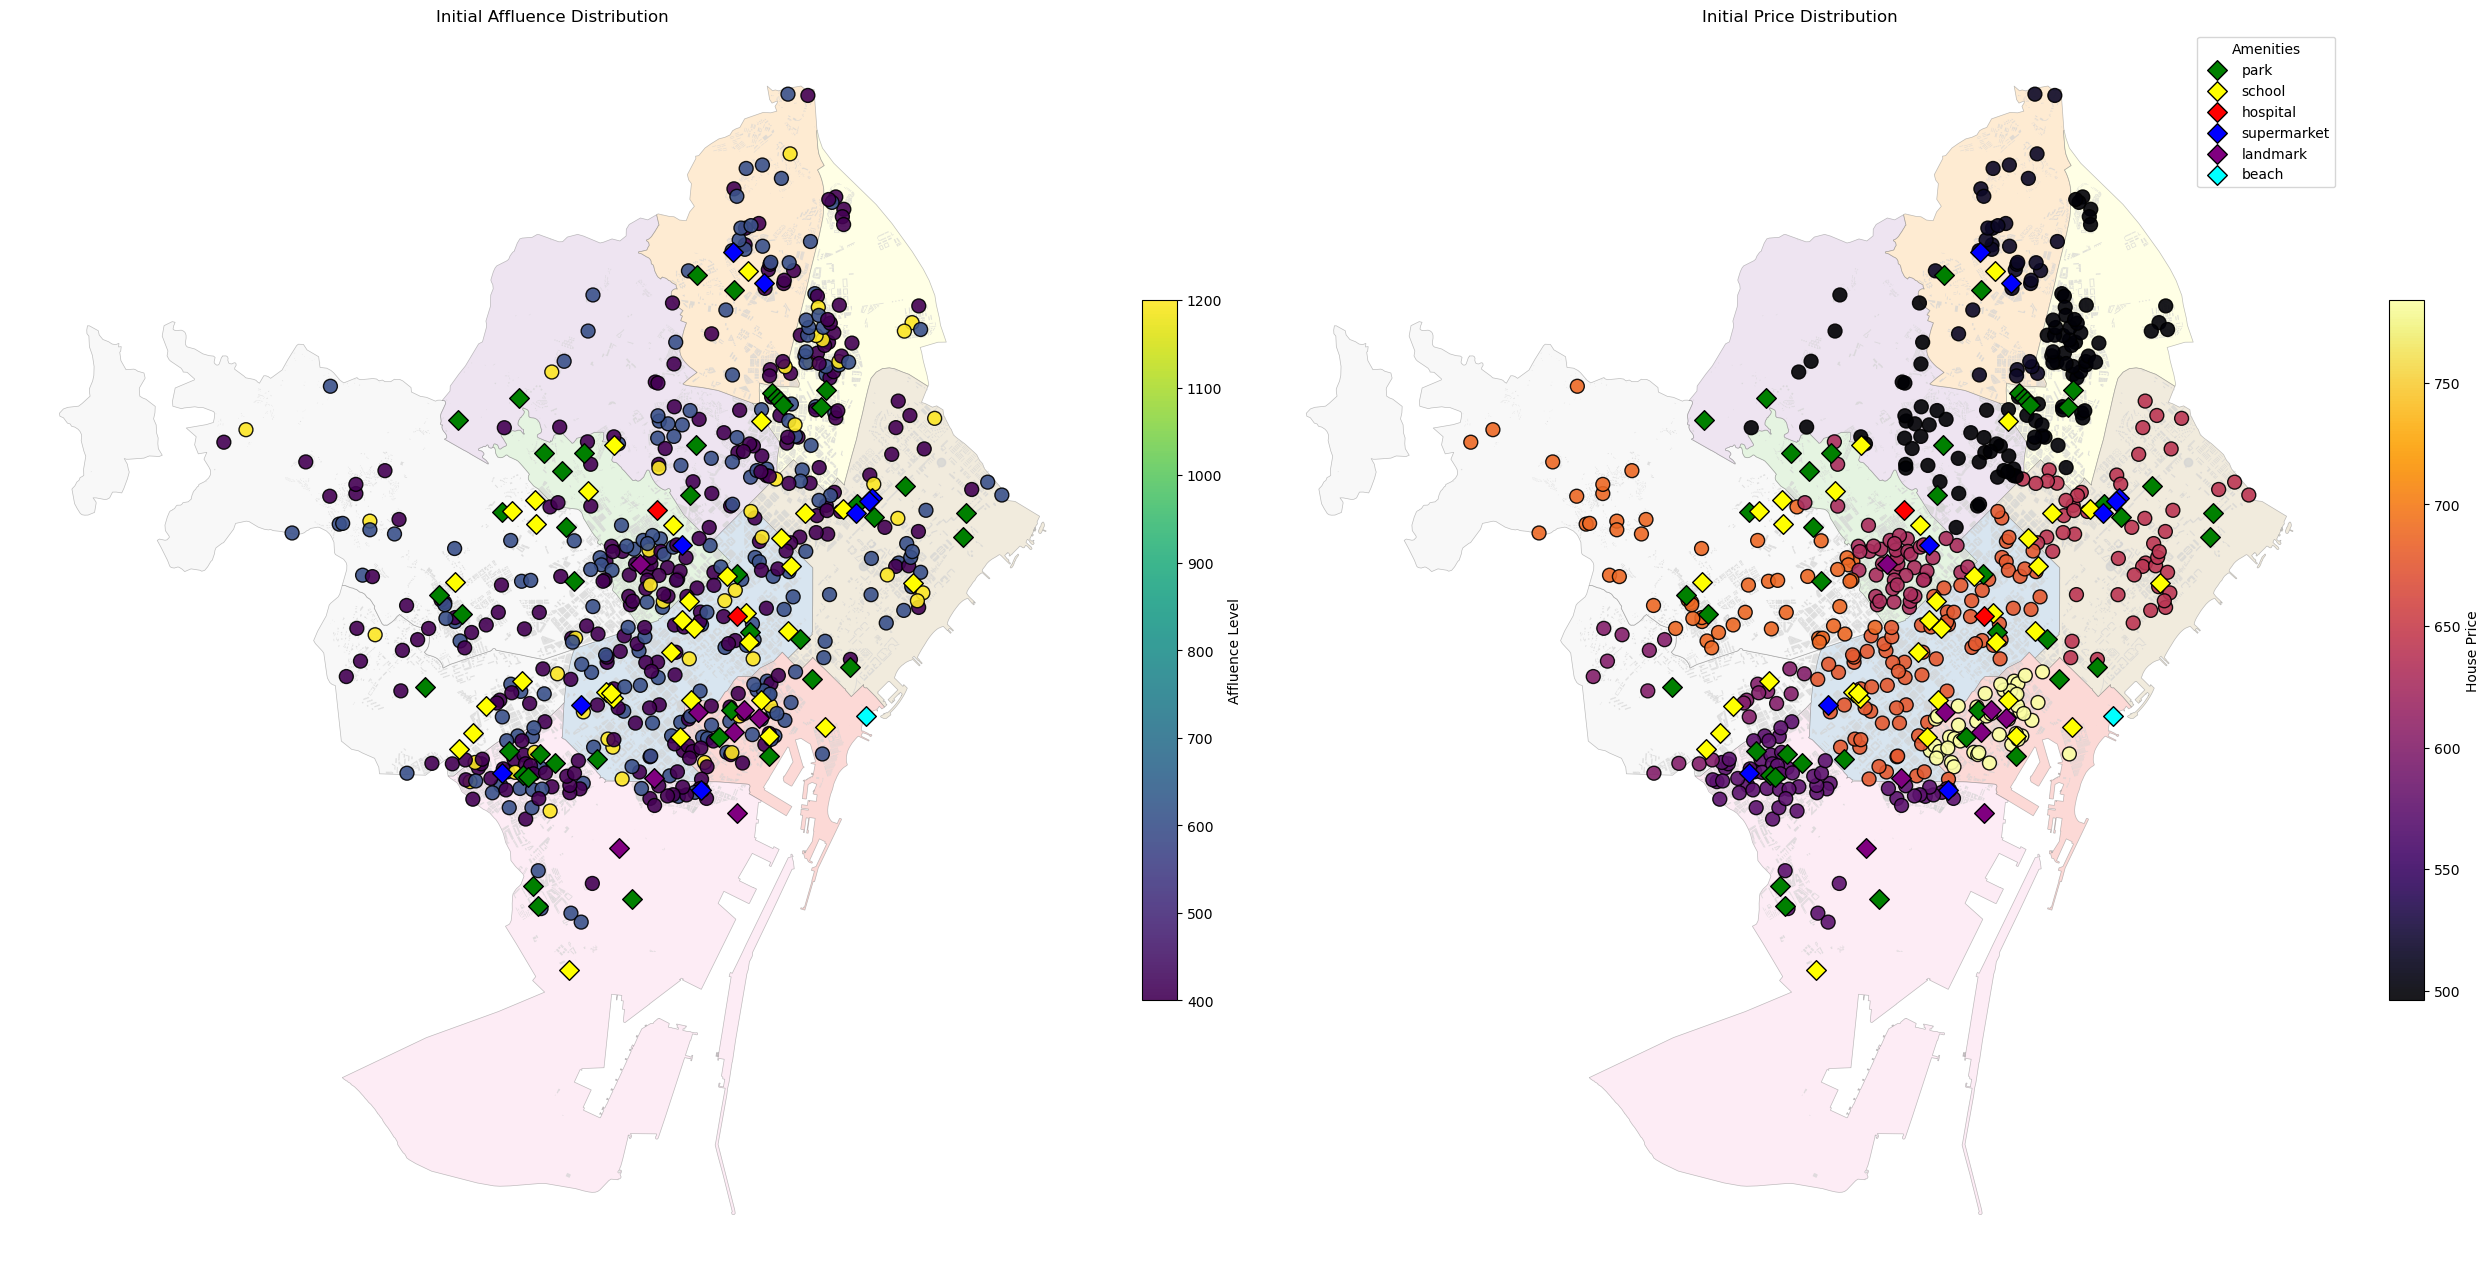

In [37]:

# Set parameters
a = [1200,600,400] # Affluence group parameters 
p = [0.1, 0.4, 0.5] # Initial affluence proportions 
weight = 0.9  # Inflationary parameter
amenity_weights = {'park': 200, 'school': 400, 'hospital': 600, 'supermarket': 200, 'landmark': 100, 'beach': 100}

# Initialize house price grid 
initial_prices = initial_price_dist(agents_with_districts, district_prices)

# Initialize affluence grid 
agent_affluence = initial_affluence_dist(num_agents, a, p, agents_with_districts)

# Set up figure with two large subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15), gridspec_kw={'width_ratios': [1, 1]})

# Plot the residential areas and districts on both subplots

districts_within_city.plot(ax = ax1, column = 'name_left', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)
districts_within_city.plot(ax = ax2, column = 'name_left', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)

residential_areas.plot(ax =ax1, color='lightgray', alpha=0.7)
residential_areas.plot(ax = ax2, color='lightgray', alpha=0.7)

# Plot Amenities
 # Plot the points for each amenity type
for i in range(len(amenities)):
    amenity = amenities[i]
    if i == 0 or amenity[2] != amenities[i - 1][2]: 
        ax1.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', label = amenity[2], s = 100, zorder = 5)
        ax2.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', label = amenity[2], s = 100, zorder = 5)
    else:
        ax1.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', s = 100, zorder = 5)
        ax2.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', s = 100, zorder = 5)
        
# Plot the initial affluence distribution with a smaller color bar
scatter_affluence = ax1.scatter(agent_affluence['longitude'], agent_affluence['latitude'], 
                                c=agent_affluence['affluence'], cmap='viridis', s=100, 
                                edgecolors='k', alpha=0.9)
ax1.set_title("Initial Affluence Distribution")
cbar_affluence = fig.colorbar(scatter_affluence, ax=ax1, fraction=0.03, pad=0.04, label='Affluence Level')  # Smaller color bar
ax1.axis("off")

# Plot the initial price distribution with a smaller color bar
scatter_price = ax2.scatter(agent_affluence['longitude'], agent_affluence['latitude'], 
                            c=agent_affluence['price'], cmap='inferno', s=100, 
                            edgecolors='k', alpha=0.9)

ax2.set_title("Initial Price Distribution")
plt.legend(loc='upper right', title="Amenities", fontsize=10)
cbar_price = fig.colorbar(scatter_price, ax=ax2, fraction=0.03, pad=0.04, label='House Price')  # Smaller color bar
ax2.axis("off")
plt.tight_layout()
plt.show()

# Calculate appropriate radius. This is done by taking horizontal distance of leftmost and rightmost agent. Then dividing this by a desired factor (10 at the moment).
range_x = max(agents_with_districts['latitude']) - min(agents_with_districts['latitude'])
radius = np.round(range_x/ 10,5)

## Simulation Step (Seems to be getting exponentially slower as agent count increases)

In [38]:
# Do the first house values calculation
vals = update_house_prices(initial_prices, weight, radius, amenities_df, amenity_weights, radius)

# Set the iterations limit
n_iterations = 500

for i in range(n_iterations):
   vals,_ = new_iteration(initial_prices, weight, radius, amenities_df, amenity_weights, radius)

   
   # Print progress every 10%
   if i % (n_iterations // 10) == 0 or i == n_iterations - 1:
      print(f"Progress: {100 * (i + 1) / n_iterations:.0f}% complete")

Progress: 0% complete
Progress: 10% complete
Progress: 20% complete
Progress: 30% complete
Progress: 40% complete
Progress: 50% complete
Progress: 60% complete
Progress: 70% complete
Progress: 80% complete
Progress: 90% complete
Progress: 100% complete


## Plot Final Map

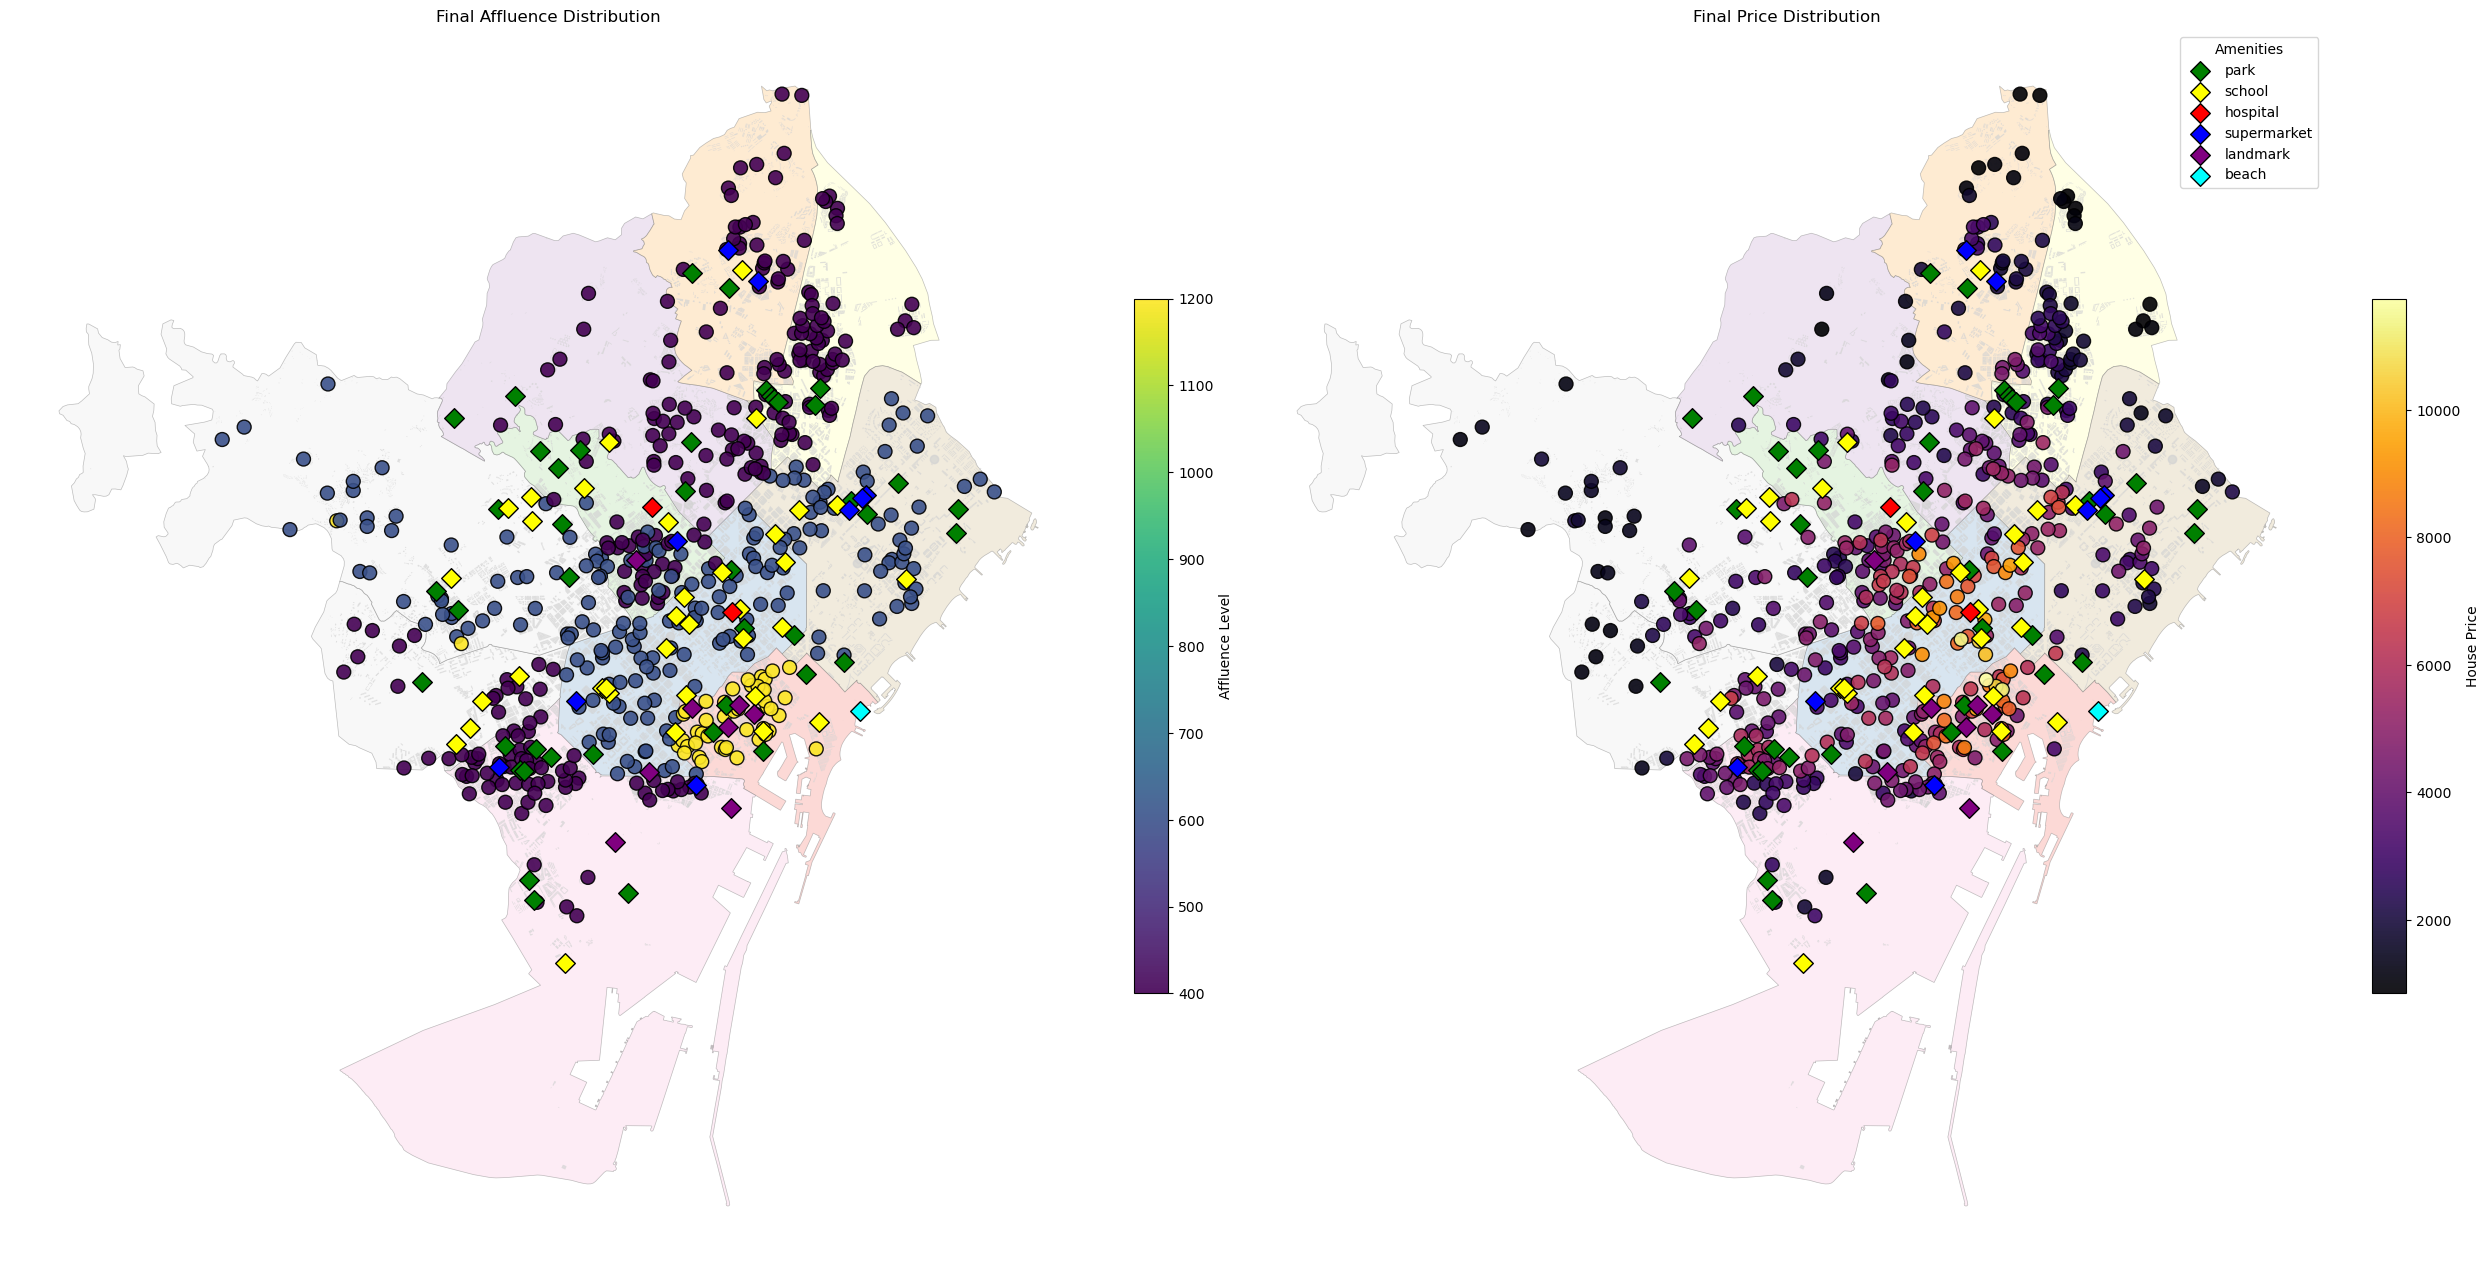

In [40]:
# Set up figure with two large subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15), gridspec_kw = {'width_ratios': [1, 1]})

# Plot the residential areas and districts on both subplots

districts_within_city.plot(ax = ax1, column = 'name_left', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)
districts_within_city.plot(ax = ax2, column = 'name_left', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)

residential_areas.plot(ax =ax1, color='lightgray', alpha=0.7)
residential_areas.plot(ax = ax2, color='lightgray', alpha=0.7)

# Plot Amenities
 # Plot the points for each amenity type
for i in range(len(amenities)):
    amenity = amenities[i]
    if i == 0 or amenity[2] != amenities[i - 1][2]: 
        ax1.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', label = amenity[2], s = 100, zorder = 5)
        ax2.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', label = amenity[2], s = 100, zorder = 5)
    else:
        ax1.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', s = 100, zorder = 5)
        ax2.scatter(amenity[0], amenity[1], color = amenity_colors[amenity[2]], marker = 'D',  edgecolors='k', s = 100, zorder = 5)
        
# Plot the initial affluence distribution with a smaller color bar
scatter_affluence = ax1.scatter(vals['longitude'], vals['latitude'], 
                                c=vals['affluence'], cmap='viridis', s=100, 
                                edgecolors='k', alpha=0.9)
ax1.set_title("Final Affluence Distribution")
cbar_affluence = fig.colorbar(scatter_affluence, ax=ax1, fraction=0.03, pad=0.04, label='Affluence Level')  # Smaller color bar
ax1.axis("off")
# Plot the initial price distribution with a smaller color bar
scatter_price = ax2.scatter(vals['longitude'], vals['latitude'], 
                            c=vals['price'], cmap='inferno', s=100, 
                            edgecolors='k', alpha=0.9)


ax2.set_title("Final Price Distribution")
plt.legend(loc='upper right', title="Amenities", fontsize=10)
cbar_price = fig.colorbar(scatter_price, ax=ax2, fraction=0.03, pad=0.04, label='House Price')  # Smaller color bar
ax2.axis("off")
plt.tight_layout()
plt.show()
